In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support



import geopandas as gpd
from shapely.geometry import Point, Polygon

# At first we mount the dataset from local file

inputdf = pd.read_csv('Crime.csv')

C:\Users\shawo\AppData\Local\Temp\ipykernel_18500\187540331.py:18: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  inputdf = pd.read_csv('Crime.csv')


In [114]:


# sneak peak in the data
inputdf.head(2)


,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


In [115]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns

(312297, 30)


Index(['Incident ID', 'Offence Code', 'CR Number', 'Dispatch Date / Time',
       'NIBRS Code', 'Victims', 'Crime Name1', 'Crime Name2', 'Crime Name3',
       'Police District Name', 'Block Address', 'City', 'State', 'Zip Code',
       'Agency', 'Place', 'Sector', 'Beat', 'PRA', 'Address Number',
       'Street Prefix', 'Street Name', 'Street Suffix', 'Street Type',
       'Start_Date_Time', 'End_Date_Time', 'Latitude', 'Longitude',
       'Police District Number', 'Location'],
      dtype='object')

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

In [116]:
# dropping the unnecessary columns
#inputdf = data
unnecessary_columns = ['Incident ID', 'Offence Code', 'CR Number', 'NIBRS Code', 'State', 'Sector', 'Beat', 'PRA', 'Address Number', 'Street Prefix', 'Street Suffix', 'Police District Number', 'Location'  ]
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Dispatch Date / Time,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,Block Address,City,Zip Code,Agency,Place,Street Name,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude
0,12/21/2018 09:13:13 PM,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,11100 BLK GEORGIA AVE,SILVER SPRING,20902.0,MCPD,Street - Bus Stop,GEORGIA,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499
1,09/13/2020 12:26:58 AM,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,25600 BLK COLTRANE DR,DAMASCUS,20872.0,MCPD,Parking Lot - Residential,COLTRANE,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115


Now we have to visualize the data and fix what to predict from these modified feature set

In [118]:


# nybb = geopandas.read_file(geopandas.datasets.get_path("nybb"))
# world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
# nybb.explore()


PROJCS["NAD83 / Maryland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37.6666666666667],PARAMETER["central_meridian",-77],PARAMETER["standard_parallel_1",38.3],PARAMETER["standard_parallel_2",39.45],PARAMETER["false_easting",1312333.33333333],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

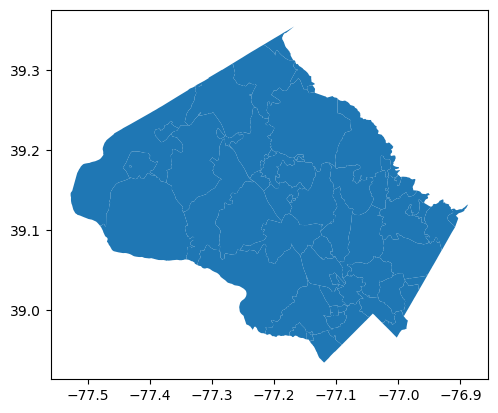

In [119]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('Zipcodes.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


<AxesSubplot:>

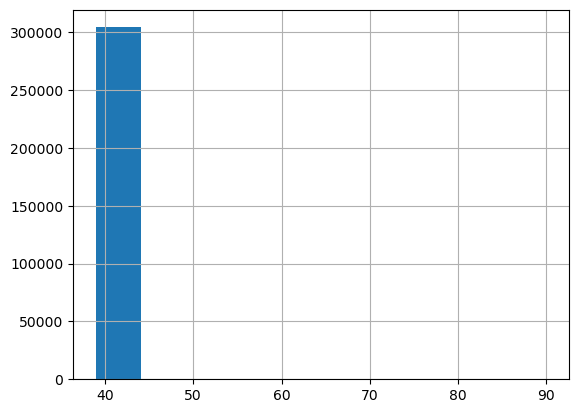

In [120]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
inputdf['Latitude'].hist()

<AxesSubplot:>

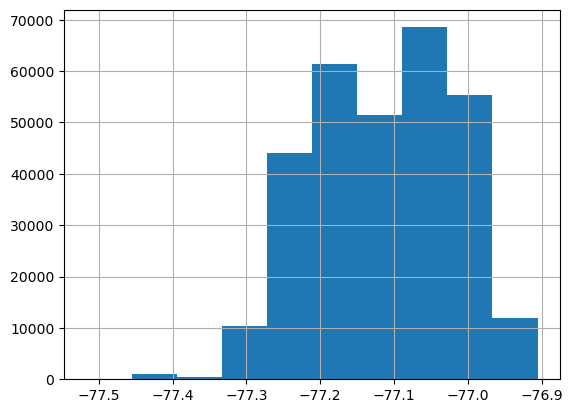

In [121]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
inputdf['Longitude'].hist()

# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [122]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

c:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Dispatch Date / Time,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,Block Address,City,Zip Code,Agency,Place,Street Name,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,geometry
0,12/21/2018 09:13:13 PM,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,11100 BLK GEORGIA AVE,SILVER SPRING,20902.0,MCPD,Street - Bus Stop,GEORGIA,AVE,12/21/2018 09:13:00 PM,NaN,39.036270,-77.049900,POINT (-77.04990 39.03627)
1,09/13/2020 12:26:58 AM,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,25600 BLK COLTRANE DR,DAMASCUS,20872.0,MCPD,Parking Lot - Residential,COLTRANE,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.277840,-77.211500,POINT (-77.21150 39.27784)
2,01/03/2019 02:48:47 AM,1,Crime Against Society,Driving Under the Influence,DRIVING UNDER THE INFLUENCE LIQUOR,ROCKVILLE,NaN,ROCKVILLE,20850.0,RCPD,Street - In vehicle,GRANDIN,AVE,01/03/2019 02:48:00 AM,01/03/2019 02:48:00 AM,39.086688,-77.144754,POINT (-77.14475 39.08669)
3,01/03/2019 02:48:47 AM,1,Other,All Other Offenses,LITTERING/TRASH DUMPING,ROCKVILLE,NaN,ROCKVILLE,20850.0,RCPD,Street - Other,GRANDIN,AVE,01/03/2019 02:48:00 AM,01/03/2019 02:48:00 AM,39.086688,-77.144754,POINT (-77.14475 39.08669)
4,07/16/2020 05:29:50 PM,1,Crime Against Property,Shoplifting,LARCENY - SHOPLIFTING,GERMANTOWN,20900 BLK FREDERICK RD,GERMANTOWN,20876.0,MCPD,Retail - Department/Discount Store,FREDERICK,RD,07/16/2020 05:29:00 PM,NaN,39.198295,-77.244900,POINT (-77.24490 39.19830)


<AxesSubplot:>

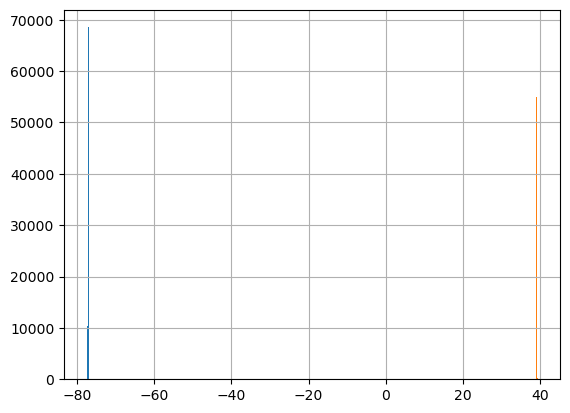

In [123]:
geo_df['Longitude'].hist()
geo_df['Latitude'].hist()

# Visualizing the Crime Data

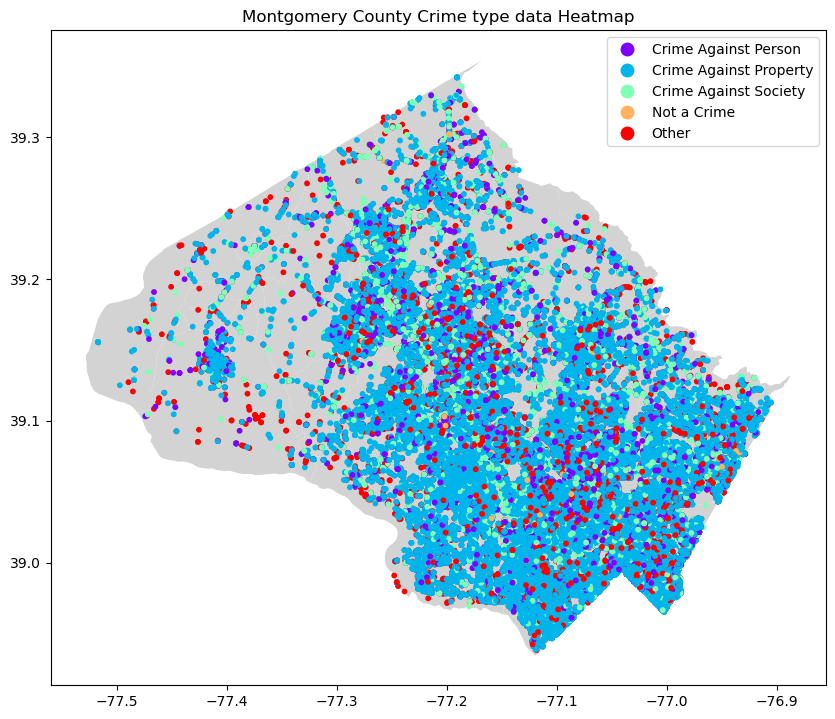

In [127]:
fig, ax = plt.subplots(figsize = (10,10))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
plt.savefig('Crime Heat Map for Location')